<a href="https://colab.research.google.com/github/Mohamedragih1/Smoking-Status-Prediction/blob/main/Explanatory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#import shap
sns.set(style="whitegrid")

# Ignore warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Display plots inline in the notebook
%matplotlib inline

In [ ]:
df = pd.read_csv("myData.csv", index_col = 0)
#df.drop('id', axis=1, inplace=True)
df

,Cholesterol,HDL,triglyceride,serum creatinine,Urine protein,ALT,age,hemoglobin,id,dental caries,smoking
0,172,40,300,1.0,1,25,55,16.5,0,0,1
1,194,57,55,1.1,1,23,70,16.2,1,1,0
2,178,45,197,0.8,1,31,20,17.4,2,0,1
3,180,38,203,1.0,1,27,35,15.9,3,1,0
4,155,44,87,0.8,1,13,30,15.4,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...
159251,238,72,47,0.8,1,26,40,14.5,159251,0,0
159252,213,64,202,0.6,1,20,50,14.5,159252,0,0
159253,189,87,45,0.6,1,9,40,10.9,159253,0,0
159254,165,55,148,1.1,1,17,50,14.4,159254,0,1


In [ ]:
X = df[['Cholesterol', 'HDL', 'triglyceride', 'serum creatinine',
       'Urine protein', 'ALT', 'age', 'hemoglobin', 'id', 'dental caries',
       ]]

y = df[['smoking']]

#create features

In [ ]:
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']

X['age category'] = pd.cut(X['age'], bins=bins, labels=labels, right=False)

hemoglobin_bins = [10, 12, 14, 16, 18]
hemoglobin_labels = ['Low', 'Normal', 'High', 'Very High']

X['hemoglobin_category'] = pd.cut(X['hemoglobin'], bins=hemoglobin_bins, labels=hemoglobin_labels, right=False)

df

,Cholesterol,HDL,triglyceride,serum creatinine,Urine protein,ALT,age,hemoglobin,id,dental caries,smoking
0,172,40,300,1.0,1,25,55,16.5,0,0,1
1,194,57,55,1.1,1,23,70,16.2,1,1,0
2,178,45,197,0.8,1,31,20,17.4,2,0,1
3,180,38,203,1.0,1,27,35,15.9,3,1,0
4,155,44,87,0.8,1,13,30,15.4,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...
159251,238,72,47,0.8,1,26,40,14.5,159251,0,0
159252,213,64,202,0.6,1,20,50,14.5,159252,0,0
159253,189,87,45,0.6,1,9,40,10.9,159253,0,0
159254,165,55,148,1.1,1,17,50,14.4,159254,0,1


##extract new features

In [ ]:
#Estimated Glomerular Filtration Rate
def calculate_egfr(serum_creatinine, age):

    kappa = 0.9
    alpha = -0.411

    egfr = 141 * min(serum_creatinine / kappa, 1) ** alpha * max(serum_creatinine / kappa, 1) ** (-1.209) * (0.993 ** age )
   # GFR = 141 × min (S_cr / κ, 1) ^ α × max(S_cr / κ, 1) ^ -1.209 × 0.993 ^ Age × 1.018 [if female] × 1.159 [if black]
    return egfr

X['kidney function index'] = X.apply(lambda row: calculate_egfr(row['serum creatinine'], row['age']), axis=1)

In [ ]:
X['serum_creatinine'] = [1.0] * len(X)
X['serum_creatinine_to_hemoglobin_ratio'] = X['serum_creatinine'] * X['hemoglobin']

In [ ]:
X = pd.get_dummies(X, columns=['age category'], prefix='age_cat')
X= pd.get_dummies(X, columns=['hemoglobin_category'], prefix='hemoglobin_cat')
X

,Cholesterol,HDL,triglyceride,serum creatinine,Urine protein,ALT,age,hemoglobin,id,dental caries,...,age_cat_40-49,age_cat_50-59,age_cat_60-69,age_cat_70-79,age_cat_80-89,age_cat_90-100,hemoglobin_cat_Low,hemoglobin_cat_Normal,hemoglobin_cat_High,hemoglobin_cat_Very High
0,172,40,300,1.0,1,25,55,16.5,0,0,...,0,1,0,0,0,0,0,0,0,1
1,194,57,55,1.1,1,23,70,16.2,1,1,...,0,0,0,1,0,0,0,0,0,1
2,178,45,197,0.8,1,31,20,17.4,2,0,...,0,0,0,0,0,0,0,0,0,1
3,180,38,203,1.0,1,27,35,15.9,3,1,...,0,0,0,0,0,0,0,0,1,0
4,155,44,87,0.8,1,13,30,15.4,4,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,238,72,47,0.8,1,26,40,14.5,159251,0,...,1,0,0,0,0,0,0,0,1,0
159252,213,64,202,0.6,1,20,50,14.5,159252,0,...,0,1,0,0,0,0,0,0,1,0
159253,189,87,45,0.6,1,9,40,10.9,159253,0,...,1,0,0,0,0,0,1,0,0,0
159254,165,55,148,1.1,1,17,50,14.4,159254,0,...,0,1,0,0,0,0,0,0,1,0


#train, test and validate split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

#drop useless features

In [ ]:
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)
X_val.drop('id', axis=1, inplace=True)

#handling outliers

##using z_score method to remove outliers

In [ ]:
combined_data = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)

In [ ]:
from scipy.stats import zscore

# Function to detect and extract outliers using Z-score
def remove_outliers_zscore(df, column, z_threshold=3):
    z_scores = zscore(combined_data[column])
    outliers = (abs(z_scores) > z_threshold)
    return df[~outliers]


# Remove outliers for each specified feature

    combined_train_df= remove_outliers_zscore(combined_data, 'age')


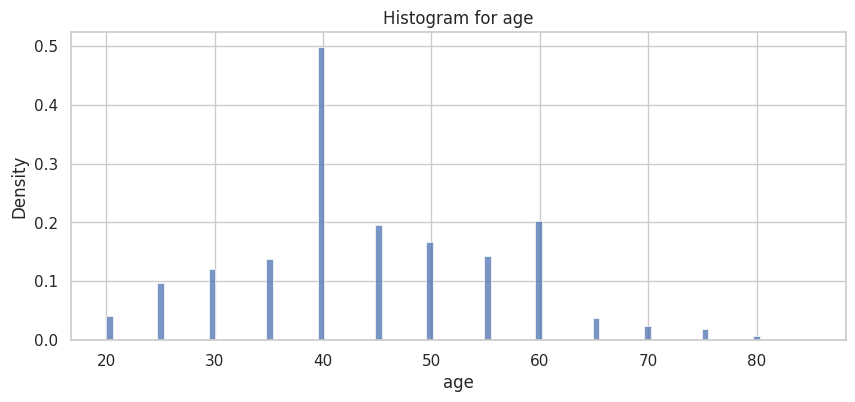

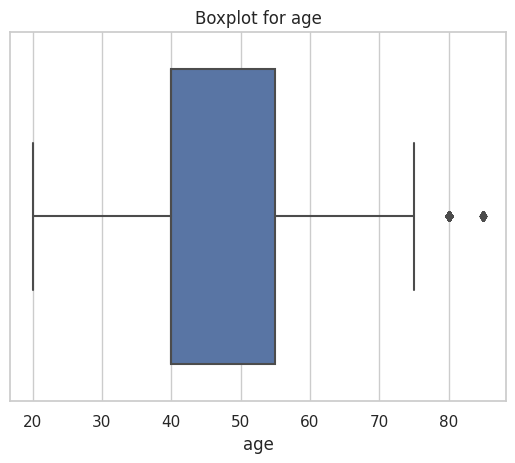

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(combined_data['age'], stat='density')
plt.title(f'Histogram for age')
plt.xlabel('age')
plt.ylabel('Density')
plt.show()

sns.boxplot(x=combined_data['age'])
plt.title('Boxplot for age')
plt.xlabel('age')
plt.show()


#using IQR METHOD TO IDENTIFY AND REMOVE OUTLIERS

In [ ]:
import pandas as pd

# Function to detect and extract outliers using IQR
def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df[~outliers]

# Remove outliers for each specified feature
    comb_train = remove_outliers_iqr(combined_data,'triglyceride')


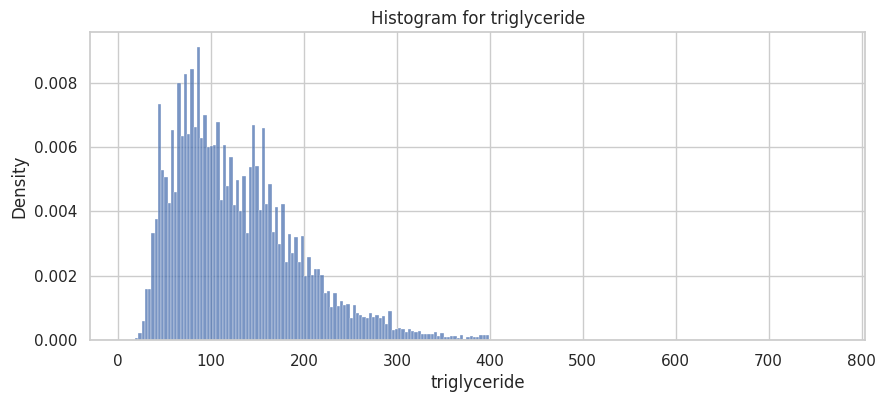

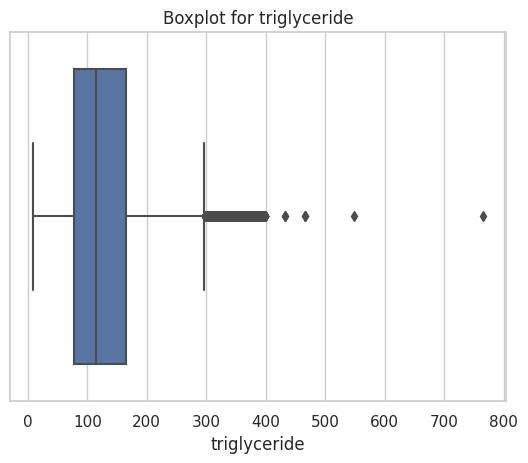

In [ ]:
plt.figure(figsize=(10, 4))

sns.histplot(combined_data['triglyceride'], stat='density')
plt.title(f'Histogram for triglyceride')
plt.xlabel('triglyceride')
plt.ylabel('Density')
plt.show()

sns.boxplot(x=combined_data['triglyceride'])
plt.title('Boxplot for triglyceride')
plt.xlabel('triglyceride')
plt.show()

In [ ]:
threshold = 300
X_train['Cholesterol'] = np.where(X_train['Cholesterol'] > threshold, threshold, X_train['Cholesterol'])

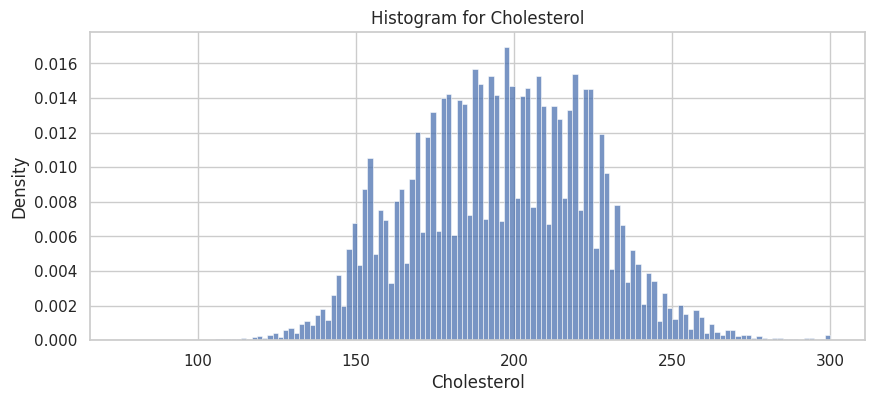

In [ ]:
plt.figure(figsize=(10, 4))

sns.histplot(X_train['Cholesterol'], stat='density')
plt.title(f'Histogram for Cholesterol')
plt.xlabel('Cholesterol')
plt.ylabel('Density')
plt.show()

In [ ]:
threshold = 100
X_train['HDL'] = np.where(X_train['HDL'] > threshold, threshold, X_train['HDL'])

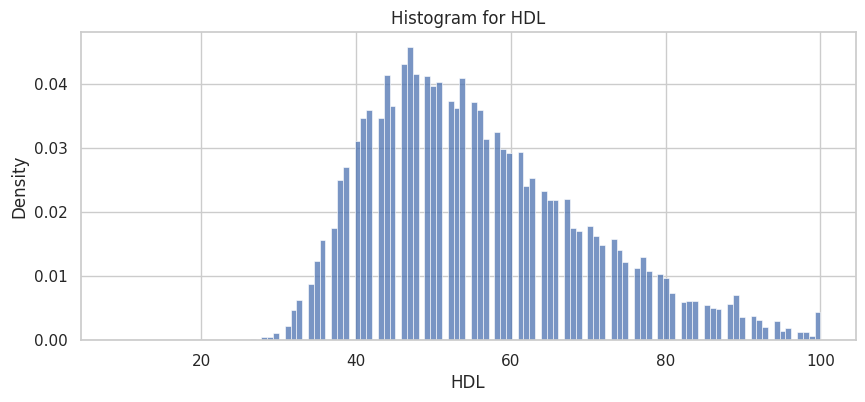

In [ ]:
plt.figure(figsize=(10, 4))

sns.histplot(X_train['HDL'], stat='density')
plt.title(f'Histogram for HDL')
plt.xlabel('HDL')
plt.ylabel('Density')
plt.show()

In [ ]:
threshold1 = 8
X_train['hemoglobin'] = np.where(X_train['hemoglobin'] < threshold1, threshold1, X_train['hemoglobin'])
threshold2 = 18.5
X_train['hemoglobin'] = np.where(X_train['hemoglobin'] > threshold2, threshold2, X_train['hemoglobin'])

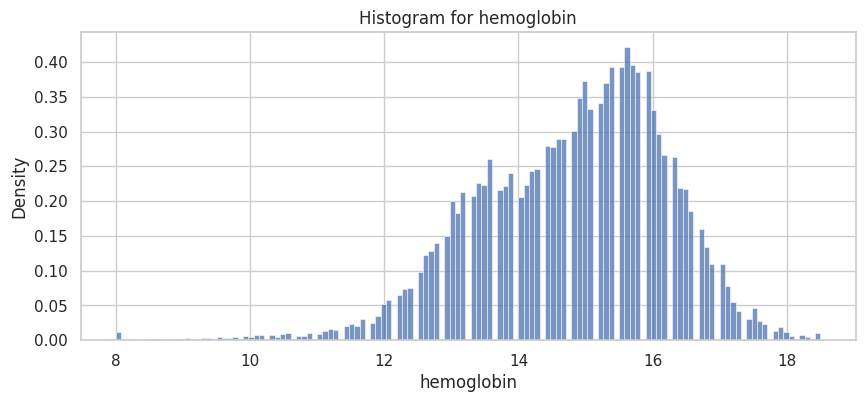

In [ ]:
plt.figure(figsize=(10, 4))

sns.histplot(X_train['hemoglobin'], stat='density')
plt.title(f'Histogram for hemoglobin')
plt.xlabel('hemoglobin')
plt.ylabel('Density')
plt.show()

In [ ]:
X_train

,Cholesterol,HDL,triglyceride,serum creatinine,Urine protein,ALT,age,hemoglobin,dental caries,kidney function index,...,age_cat_40-49,age_cat_50-59,age_cat_60-69,age_cat_70-79,age_cat_80-89,age_cat_90-100,hemoglobin_cat_Low,hemoglobin_cat_Normal,hemoglobin_cat_High,hemoglobin_cat_Very High
60700,179,60,48,0.6,1,11,40,11.8,0,125.765801,...,1,0,0,0,0,0,1,0,0,0
44065,210,67,98,0.6,1,24,65,16.3,0,105.510036,...,0,0,1,0,0,0,0,0,0,1
39538,154,48,45,0.6,1,15,55,13.4,0,113.188235,...,0,1,0,0,0,0,0,1,0,0
105427,230,54,83,0.7,1,13,55,14.6,0,106.239534,...,0,1,0,0,0,0,0,0,1,0
148669,163,54,117,0.9,1,30,30,13.8,0,114.208011,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,225,42,204,1.0,1,87,30,15.3,0,100.548538,...,0,0,0,0,0,0,0,0,1,0
103694,169,48,156,0.9,1,26,40,15.9,1,106.460635,...,1,0,0,0,0,0,0,0,1,0
131932,166,74,93,0.6,1,13,45,13.8,0,121.425193,...,1,0,0,0,0,0,0,1,0,0
146867,175,42,86,1.0,1,53,60,15.0,0,81.442898,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127404 entries, 60700 to 121958
Data columns (total 24 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Cholesterol                           127404 non-null  int64  
 1   HDL                                   127404 non-null  int64  
 2   triglyceride                          127404 non-null  int64  
 3   serum creatinine                      127404 non-null  float64
 4   Urine protein                         127404 non-null  int64  
 5   ALT                                   127404 non-null  int64  
 6   age                                   127404 non-null  int64  
 7   hemoglobin                            127404 non-null  float64
 8   dental caries                         127404 non-null  int64  
 9   kidney function index                 127404 non-null  float64
 10  serum_creatinine                      127404 non-null  float64
 

#removing null values

In [ ]:
# numerical_columns = ['Cholesterol', 'HDL', 'triglyceride', 'serum creatinine',
#        'Urine protein', 'ALT', 'age', 'hemoglobin',  'dental caries']
# for column in numerical_columns:
#  X_train[column].fillna(df[column].mean(), inplace=True)

#Handling skewness of features

In [ ]:
print(f"ALT skewness before log transformation : {skew(X_train['ALT'])}")
print(f"HDL skewness before log transformation : {skew(X_train['HDL'])}")
X_train['ALT'] = np.log(X_train['ALT'])
X_train['HDL'] = np.log(X_train['HDL'])
print(f"ALT skewness after log transformation : {skew(X_train['ALT'])}")
print(f"HDL skewness after log transformation : {skew(X_train['HDL'])}")

ALT skewness before log transformation : 39.52472074573461
HDL skewness before log transformation : 0.7138676726997761
ALT skewness after log transformation : 0.350716262026544
HDL skewness after log transformation : 0.17600918587787515


ALT
0.350716262026544


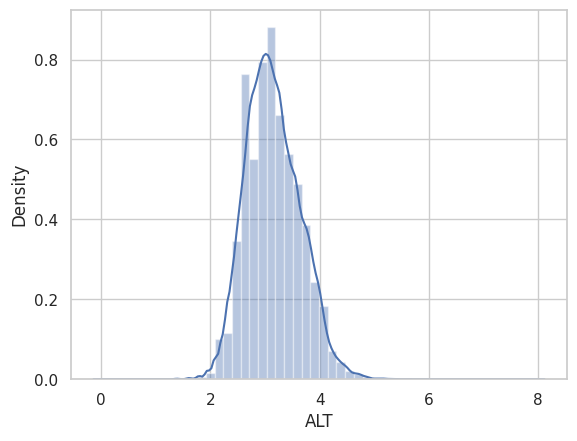

HDL
0.17600918587787515


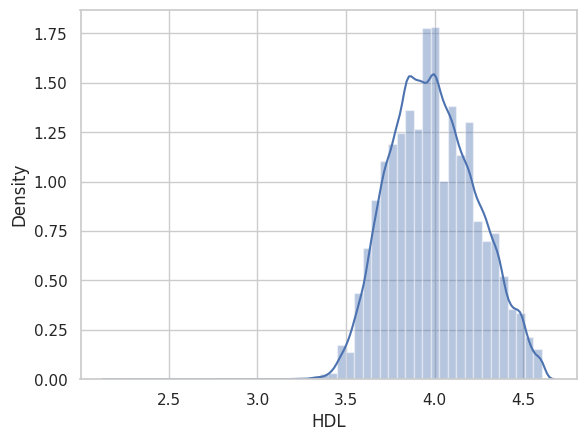

In [ ]:
transformed_columns = ['ALT', 'HDL']
for column in transformed_columns:
  print(column)
  print(skew(X_train[column]))
  plt.figure()
  sns.distplot(X_train[column])
  plt.show()

##NORMALIZING USING RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler
features_to_scale = ['Urine protein', 'serum creatinine']

# Create a subset DataFrame with only the specified features
subset_data = [features_to_scale]

# Assuming 'data' is your dataset
scaler = RobustScaler()
sub_data=X_train.set_index(['Urine protein','serum creatinine'])
scaled_data= scaler.fit_transform(sub_data)

In [ ]:
scaled_data


array([[-0.4047619 ,  0.29913218, -0.75      , ...,  0.        ,
        -1.        ,  0.        ],
       [ 0.33333333,  0.61242465, -0.18181818, ...,  0.        ,
        -1.        ,  1.        ],
       [-1.        , -0.33440133, -0.78409091, ...,  1.        ,
        -1.        ,  0.        ],
       ...,
       [-0.71428571,  0.894556  , -0.23863636, ...,  1.        ,
        -1.        ,  0.        ],
       [-0.5       , -0.71351429, -0.31818182, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.35714286, -0.16228016,  0.79545455, ...,  0.        ,
         0.        ,  0.        ]])

##normalizing using standard scaler

In [ ]:

sc_X=StandardScaler()
x_train_mod=X_train.drop(features_to_scale,axis=1)
x_test_mod=X_test.drop(features_to_scale,axis=1)
x_val_mod=X_val.drop(features_to_scale,axis=1)
x_train=sc_X.fit_transform(x_train_mod)
x_validate=sc_X.fit_transform(x_val_mod)
x_test=sc_X.fit_transform(x_test_mod)

In [ ]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_val.to_csv('X_validate.csv', index=False)
y_val.to_csv('y_validate.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)